<a href="https://colab.research.google.com/github/amnbot/Mais202/blob/main/MoodFaces.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Manga Faces Mood Classifier

Dataset: https://www.kaggle.com/datasets/mertkkl/manga-facial-expressions

References: 

1.   [ \[Pytorch\] - Manga Facial Expression Classificationt](https://www.kaggle.com/code/mertkkl/pytorch-manga-facial-expression-classification/)
2.   [POZZ (MAIS Hacks submission)](https://github.com/amnbot/POZZ/blob/master/jupyter/model.ipynb)


**To look at:**

https://stackoverflow.com/questions/61858768/why-is-the-accuracy-of-my-pretrained-resnet-152-model-so-low


In [2]:
# Imports

import torchvision
import torchvision.datasets as datasets # For importing dataset
import torchvision.models as models # For ResNet-50

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim

import numpy as np


**From PyTorch [documentation](https://pytorch.org/hub/pytorch_vision_resnet/):**

"All pre-trained models expect input images normalized in the same way, i.e. mini-batches of 3-channel RGB images of shape (3 x H x W), where H and W are expected to be at least 224. The images have to be loaded in to a range of [0, 1] and then normalized using mean = [0.485, 0.456, 0.406] and std = [0.229, 0.224, 0.225]."

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu' # Device to send data and model to

In [4]:
# Image preprocessing
from PIL import Image
from torchvision import transforms

preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), # These values seem to be a sort of "convention" (found in docs and other projects)
])

In [5]:
# Load the dataset
dataset = datasets.ImageFolder('/content/drive/MyDrive/MAIS 202/Project/Tests/manga-faces', transform=preprocess)
print(len(dataset))
dataset_size = len(dataset)

455


In [6]:
# Split the dataset into training and testing dataset
# Using a 80 % of data for training and 20 % for training
train_size = int(0.8 * dataset_size)
num_display_images = 5
test_size = dataset_size - train_size - num_display_images
train_ds, test_ds, display_imgs = data.random_split(dataset, [train_size, test_size, num_display_images])

In [7]:
train_loader = data.DataLoader(train_ds, shuffle=True, batch_size=15)
test_loader = data.DataLoader(test_ds, shuffle=True, batch_size=10)
display_loader = data.DataLoader(display_imgs, shuffle=True, batch_size=num_display_images)

[Visualizing a grid of images](https://pytorch.org/vision/stable/auto_examples/plot_visualization_utils.html#sphx-glr-auto-examples-plot-visualization-utils-py)

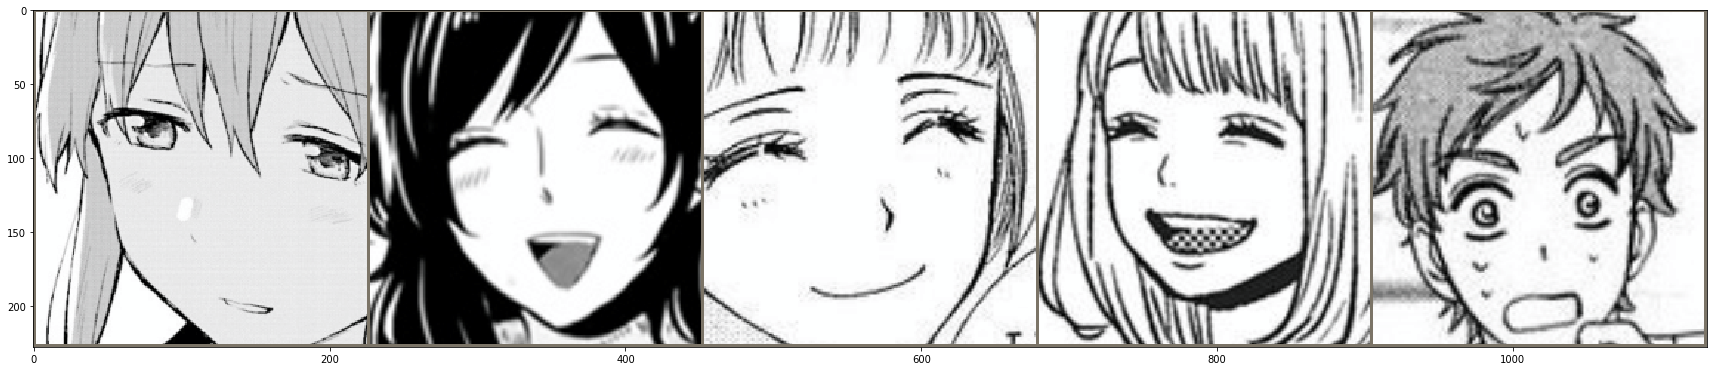

In [8]:
# Display the images (for preprocessing)
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import torchvision.transforms.functional as Func

def show(imgs):
  ax = plt.subplots(figsize = (30, 90))
  inp = imgs.numpy().transpose((1,2,0))
  mean = np.array([0.485, 0.456, 0.406])
  std = np.array([0.229, 0.224, 0.225])
  inp = std * inp + mean
  inp = np.clip(inp, 0, 1)
  plt.imshow(inp, interpolation='nearest')

inputs, classes = next(iter(display_loader))
grid = make_grid(inputs)
show(grid)

**From PyTorch [documentation](https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html)**

"By default, when we load a pretrained model all of the parameters have .requires_grad=True, which is fine if we are training from scratch or finetuning. However, if we are feature extracting and only want to compute gradients for the newly initialized layer then we want all of the other parameters to not require gradients. This will make more sense later."

In [9]:
criter = nn.CrossEntropyLoss()
model = models.resnet50(pretrained=True)

# Replace the last fully-connected (fc) layer since we only have 7 classes
for param in model.parameters():
    param.requires_grad  = False

in_feats = model.fc.in_features
num_classes = 7
model.fc = nn.Linear(in_feats, num_classes)
model = model.to(device) # Move model to device

optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.001)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [10]:
# Training function (training done twice, once for the last layer, and another time for the entire model)

def train_model(model, epoch, loss_lst):
  model.train()
  running_loss = 0

  for batch, (inputs, labels) in enumerate(train_loader):
    inputs, labels = inputs.to(device), labels.to(device) # Move data to device
    optimizer.zero_grad()
    outputs = model(inputs)
    loss = criter(outputs, labels)
    loss.backward()
    optimizer.step()
    running_loss += loss.item()*inputs.size(0)

    if (batch % 5 == 0):
      print(f'Epoch: {epoch} \t Loss: {loss}')
  
  running_loss /= len(train_loader.dataset)
  loss_lst.append(running_loss)
  print(f'Average loss: {running_loss}')

From [docs](https://pytorch.org/docs/stable/generated/torch.argmax.html):



```
>>> a = torch.randn(4, 4)
>>> a
tensor([[ 1.3398,  0.2663, -0.2686,  0.2450],
        [-0.7401, -0.8805, -0.3402, -1.1936],
        [ 0.4907, -1.3948, -1.0691, -0.3132],
        [-1.6092,  0.5419, -0.2993,  0.3195]])
>>> torch.argmax(a, dim=1)
tensor([ 0,  2,  0,  1])
```



In [11]:
# Testing function

def test_model(model, loader):
  total = 0
  correct = 0

  model.eval()
  with torch.no_grad():
    
    for batch, (inputs, labels) in enumerate(loader):
      inputs, labels = inputs.to(device), labels.to(device) # Move data to device

      outputs = model(inputs)
      # Use dim=1 to keep an array of the indices of the max values for each output
      pred = outputs.argmax(dim = 1, keepdim = False)
      res = torch.eq(pred, labels)
      for r in res:
        total += 1
        if r == True:
          correct += 1
      if (batch % 5 == 0):
        print(f'Testing Accuracy: {correct} / {total} ({round((correct / total), 2)} %)')

In [12]:
# Train and test last layer

num_epochs_last_layer = 5
print('Training last layer...')
train_loss = []
for epoch in range(1, num_epochs_last_layer + 1):
  train_model(model, epoch, train_loss)

# Test the last layer
test_model(model, train_loader)
test_model(model, test_loader)

Training last layer...
Epoch: 1 	 Loss: 2.138216733932495
Epoch: 1 	 Loss: 2.478501319885254
Epoch: 1 	 Loss: 1.6873623132705688
Epoch: 1 	 Loss: 1.8058204650878906
Epoch: 1 	 Loss: 1.4743595123291016
Average loss: 1.9246409076910753
Epoch: 2 	 Loss: 1.749512791633606
Epoch: 2 	 Loss: 1.6028754711151123
Epoch: 2 	 Loss: 1.3959859609603882
Epoch: 2 	 Loss: 1.6182113885879517
Epoch: 2 	 Loss: 1.7711201906204224
Average loss: 1.6374163666924277
Epoch: 3 	 Loss: 1.33754301071167
Epoch: 3 	 Loss: 1.4356720447540283
Epoch: 3 	 Loss: 1.7106552124023438
Epoch: 3 	 Loss: 1.5247761011123657
Epoch: 3 	 Loss: 1.2868725061416626
Average loss: 1.4779027592349838
Epoch: 4 	 Loss: 1.4077322483062744
Epoch: 4 	 Loss: 1.369390606880188
Epoch: 4 	 Loss: 1.3253411054611206
Epoch: 4 	 Loss: 1.1445651054382324
Epoch: 4 	 Loss: 1.278883457183838
Average loss: 1.3407895440583701
Epoch: 5 	 Loss: 1.3580411672592163
Epoch: 5 	 Loss: 1.1281025409698486
Epoch: 5 	 Loss: 1.14276921749115
Epoch: 5 	 Loss: 1.2042697

[1.9246409076910753, 1.6374163666924277, 1.4779027592349838, 1.3407895440583701, 1.1860555719870787]


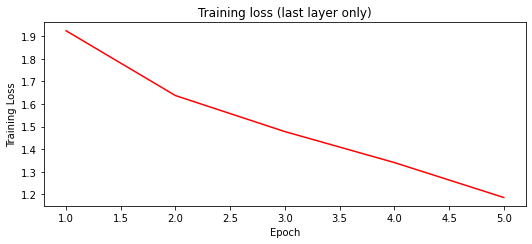

In [20]:
print(train_loss)

plt.rcParams["figure.figsize"] = [7.50, 3.50]
plt.rcParams["figure.autolayout"] = True
plt.title("Training loss (last layer only)")
plt.plot(range(1, len(train_loss) + 1), train_loss, color="red")
plt.ylabel('Training Loss')
plt.xlabel('Epoch')
plt.show()

In [21]:
# Set requires_grad = True for the layer
for param in model.parameters():
  param.requires_grad = True

# Train entire model
num_epochs_entire_model = 5
model_train_loss = []
print('Training entire model...')
for epoch in range(1, num_epochs_entire_model + 1):
  train_model(model, epoch, model_train_loss)

# Test entire model
test_model(model, train_loader)
test_model(model, test_loader)

Training entire model...
Epoch: 1 	 Loss: 0.8173198103904724


KeyboardInterrupt: ignored

In [ ]:
print(model_train_loss)

plt.rcParams["figure.figsize"] = [7.50, 3.50]
plt.rcParams["figure.autolayout"] = True
plt.title("Training loss (full model)")
plt.plot(range(1, len(model_train_loss) + 1), model_train_loss, color="red")
plt.ylabel('Training Loss')
plt.xlabel('Epoch')
plt.show()

In [18]:
"""
Show a grid of the images, the prediction VS the expected answer for the testing methods?
Show a graph for training accuracy and testing accuracy (just make the arrays..., running accuracy???)
Make a validation set? Idk man...
"""

'\nShow a grid of the images, the prediction VS the expected answer for the testing methods?\nShow a graph for training accuracy and testing accuracy (just make the arrays..., running accuracy???)\nMake a validation set? Idk man...\n'

In [19]:
model_scripted = torch.jit.script(model) # Export to TorchScript
model_scripted.save('model_scripted_1.pt') # Save